In [1]:
# ------------------------
## ----import libraries
# ------------------------
import os,sys
import numpy as np
# xarray
import xarray as xr
# plot
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.ticker as mticker
from matplotlib.colors import Colormap
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [7]:
CB_colors = {
	'blue':	'#377eb8',
	'orange':  '#ff7f00',
	'green':   '#4daf4a',
	'pink':	'#f781bf',
	'brown':   '#a65628',
	'purple':  '#984ea3',
	'gray':	'#999999',
	'red': 	'#e41a1c',
	'yellow':  '#dede00'
}

In [2]:
from dask.distributed import Client
c = Client()
# c = Client(n_workers=6, threads_per_worker=1, memory_limit="8 GiB",local_directory="/gpfsscratch/rech/cli/uor98hu/dask_tmp/")
c

/linkhome/rech/genlop01/uor98hu/.local/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36899 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36899/status,
Dashboard: http://127.0.0.1:36899/status,Workers: 8
Total threads: 40,Total memory: 188.15 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46667,Workers: 8
Dashboard: http://127.0.0.1:36899/status,Total threads: 40
Started: Just now,Total memory: 188.15 GiB
Comm: tcp://127.0.0.1:33385,Total threads: 5
Dashboard: http://127.0.0.1:46629/status,Memory: 23.52 GiB
Nanny: tcp://127.0.0.1:37287,


# Load data

In [3]:
chunk_size = {"x":500,"y":500}

# horizontal scale factors
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr = xr.open_dataset(diri+'mesh_hgr.nc',chunks=chunk_size).squeeze()
tmask = mesh_hgr.tmask
e1t = mesh_hgr.e1t.fillna(0)
e2t = mesh_hgr.e2t.fillna(0)

# SLA of the three experiments corrected for the GMSL 
path = '/gpfswork/rech/cli/uor98hu/MYDATA/SSH/'
dsGAI =xr.open_dataset(path+'GAI/eORCA025.L75-IMHOTEP.GAI_y1980_2018.1m_sossheigCorrected.nc',chunks=chunk_size)
dsAI = xr.open_dataset(path+'AI/eORCA025.L75-IMHOTEP.AI_y1980_2018.1m_sossheigCorrected.nc', chunks=chunk_size)
dsS = xr.open_dataset(path+'S/eORCA025.L75-IMHOTEP.S_y1980_2018.1m_sossheigCorrected.nc', chunks=chunk_size)

# mask of the Beaufort Gyre Region box (BGR box)
maskBG = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/TRANSPORT_WP1/BGRmaskobs.nc', chunks={"x":500,"y":500}).BGRmask.squeeze()

# Compute the SLA time series

In [4]:
# selecting only the SLA in the BGR box
sshGAI = dsGAI.sossheig.where(maskBG,drop=True)
sshAI = dsAI.sossheig.where(maskBG,drop=True)
sshS = dsS.sossheig.where(maskBG,drop=True)

# Constructing the spatial weights for the computation of the weighted spatial average of the SLA in the BGR box
bt = (e1t * e2t).load() # area of each cell
btboxBG = bt.where(maskBG,drop=True)
tmaskboxBG = tmask.where(maskBG,drop=True)
oceanArea = (btboxBG * tmaskboxBG[0])  #tmask : 1 on ocean, 0 on land
totalOceanArea = oceanArea.sum()
WeightboxBG = (oceanArea/totalOceanArea)

# putting the SLA of the different experiments at the same reference
sshGAIprime = sshGAI - sshGAI.mean("time_counter")
sshAIprime = sshAI - sshAI.mean("time_counter")
sshSprime = sshS - sshS.mean("time_counter")

# weighted spatial average of the SLA in the BGR box
sshGAIboxBG =(sshGAIprime * WeightboxBG).sum(('x','y'))
sshAIboxBG = (sshAIprime  * WeightboxBG).sum(('x','y'))
sshSboxBG  = (sshSprime   * WeightboxBG).sum(('x','y'))

In [5]:
# compute the sensitivy differences of the time series
diffWP1GAI_S  = sshGAIboxBG - sshSboxBG
diffWP1GAI_AI = sshGAIboxBG - sshAIboxBG
diffWP1AI_S   = sshAIboxBG -sshSboxBG

# compute the linear trend of the SLA over 2005-2018

In [6]:
# select on the period of interest of the difference for the computation
diffWP1GAI_AIshort = diffWP1GAI_AI.sel(time_counter=slice('2005','2018'))
diffWP1AI_Sshort = diffWP1AI_S.sel(time_counter=slice('2005','2018'))
diffWP1GAI_Sshort = diffWP1GAI_S.sel(time_counter=slice('2005','2018'))

In [8]:
# the linear trend is computed for the yearly time series in mm/yr

# for GREENLAND
diffWP1GAI_AIshort1y = diffWP1GAI_AIshort.groupby('time_counter.year').mean('time_counter')
lin_reg = (diffWP1GAI_AIshort1y*1e3).polyfit('year', deg=1)
polyfit_coeff = lin_reg.polyfit_coefficients.values
trcurveGAI_AI = polyfit_coeff[0]*diffWP1GAI_AIshort1y.year.values + polyfit_coeff[1]

# for RIVERS
diffWP1AI_Sshort1y = diffWP1AI_Sshort.groupby('time_counter.year').mean('time_counter')
lin_reg = (diffWP1AI_Sshort1y*1e3).polyfit('year', deg=1)
polyfit_coeffRivers = lin_reg.polyfit_coefficients.values
trcurveAI_S = polyfit_coeffRivers[0]*diffWP1AI_Sshort1y.year.values + polyfit_coeffRivers[1]

# for Gr+Riv
diffWP1GAI_Sshort1y = diffWP1GAI_Sshort.groupby('time_counter.year').mean('time_counter')
lin_reg = (diffWP1GAI_Sshort1y*1e3).polyfit('year', deg=1)
polyfit_coeffTot = lin_reg.polyfit_coefficients.values
trcurveGAI_S = polyfit_coeffTot[0]*diffWP1GAI_Sshort1y.year.values + polyfit_coeffTot[1]

time = [diffWP1GAI_AIshort.time_counter[6 + i].values for i in np.arange(0,168,12)]

[ 7.10106695e-03 -1.27286754e+01]
CPU times: user 2.13 s, sys: 235 ms, total: 2.37 s
Wall time: 28.5 s


In [9]:

time4plot = [time[0],time[-1]]
trGAI_AI4plot = [trcurveGAI_AI[0],trcurveGAI_AI[-1]]
trAI_S4plot = [trcurveAI_S[0],trcurveAI_S[-1]] 
trGAI_S4plot = [trcurveGAI_S[0],trcurveGAI_S[-1]]

In [10]:
print(polyfit_coeff[0])
print(polyfit_coeffRivers[0])
print(polyfit_coeffTot[0])

1.4745899179534685
-1.4674888510038855
0.007101066949582851


# figure with the running average

In [8]:
sshGAIboxBGrllmean = sshGAIboxBG.rolling(time_counter=12).mean()
sshAIboxBGrllmean = sshAIboxBG.rolling(time_counter=12).mean()
sshSboxBGrllmean = sshSboxBG.rolling(time_counter=12).mean()

diffWP1GAI_Srllmean = diffWP1GAI_S.rolling(time_counter=12).mean()
diffWP1GAI_AIrllmean = diffWP1GAI_AI.rolling(time_counter=12).mean()
diffWP1AI_Srllmean = diffWP1AI_S.rolling(time_counter=12).mean()


CPU times: user 165 ms, sys: 4.46 ms, total: 169 ms
Wall time: 519 ms


In [9]:
(diffWP1GAI_Srllmean*1000).std().values

array(3.70222551)

ts_SSH_boxBGobs_rllmean4paper.jpg


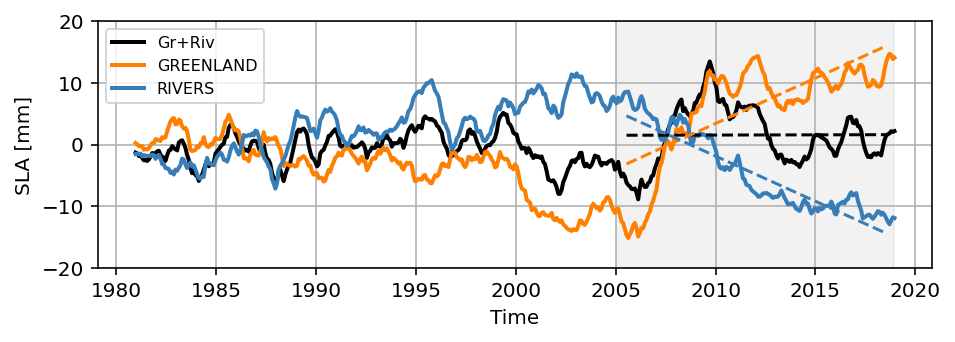

In [12]:
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/" # plot directory
namo = 'ts_SSH_boxBGobs_rllmean4paper.jpg'
tt = diffWP1GAI_Srllmean.time_counter

print(namo)
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(19*cm, 5.75*cm), facecolor='none', dpi=72*2)

lim1 = -20
lim2 = 20

plt.plot(tt, (diffWP1GAI_Srllmean*1000), color='k',linewidth=2)
plt.plot(tt, (diffWP1GAI_AIrllmean*1000), linewidth=2,color=CB_colors['orange'])
plt.plot(tt, (diffWP1AI_Srllmean*1000), linewidth=2,color=CB_colors['blue'])

plt.plot(time4plot,trGAI_S4plot,color='k',linestyle='dashed')
plt.plot(time4plot,trGAI_AI4plot,color=CB_colors['orange'],linestyle='dashed')
plt.plot(time4plot,trAI_S4plot,color=CB_colors['blue'],linestyle='dashed')

plt.axvspan('2005', '2018-12', color="grey", alpha=0.1)
plt.ylim(lim1,lim2)

plt.title('')
plt.grid()
plt.legend(['Gr+Riv',"GREENLAND","RIVERS"], loc="upper left", fontsize=8)
plt.ylabel('SLA [mm]')
plt.xlabel('Time'); 

# plt.show()
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight', transparent=True) #,edgecolor='none', bbox_inches='tight'
# plt.close(fig)

In [14]:
diffWP1GAI_Srllmean.max().values

array(0.01350549)